# 1.Imports

In [2]:
import os
import re
import shutil
import gzip
import nibabel as nib
#!pip install pynrrd
import nrrd

import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

In [3]:
# "!"" means it is a shell command
#!wget     https://heibox.uni-heidelberg.de/f/eef4cf141a4746d2bf45/?dl=1 

In [4]:
# unzip the file -> use the name, which is provided in the above output!
#!unzip    'index.html?dl=1.7'


In [5]:
train = True # Should the model be trained or should only be the model loaded and inferred
learning_rate = 0.001
max_num_epochs = 100 # Maximum number of epochs. Early stopping can cause that this is not reached.
early_stopping_patience = 5 # How many times in a row the validation loss is higher than the lowest recorded one without stopping training
batch_size = 16

# 2. Data Splitting
Rather than splitting the images, patients are splitted. This is because each patient is contained with multiple images. If some of these images from one patient end up in the training set and some in the test set, the model has already overfitted the physiology of that specific patient and test results are worse than on truly unseen data.

In [5]:
patients = np.arange(1,101,1)
labels = [int((i - 1) / (100/5)) for i in patients] # List where first 20 entries are 0, next 20 entries are 1 etc.
assert labels.count(0) == 20 and labels.count(4) == 20
X_train, X_test, y_train, y_test = train_test_split(patients, labels, test_size=0.1, stratify=labels, random_state=1) # It stratifies over the labels given
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=round(1 - (8/9),2), stratify=y_train, random_state=1) #1 - (8/9) x 90% = 10%

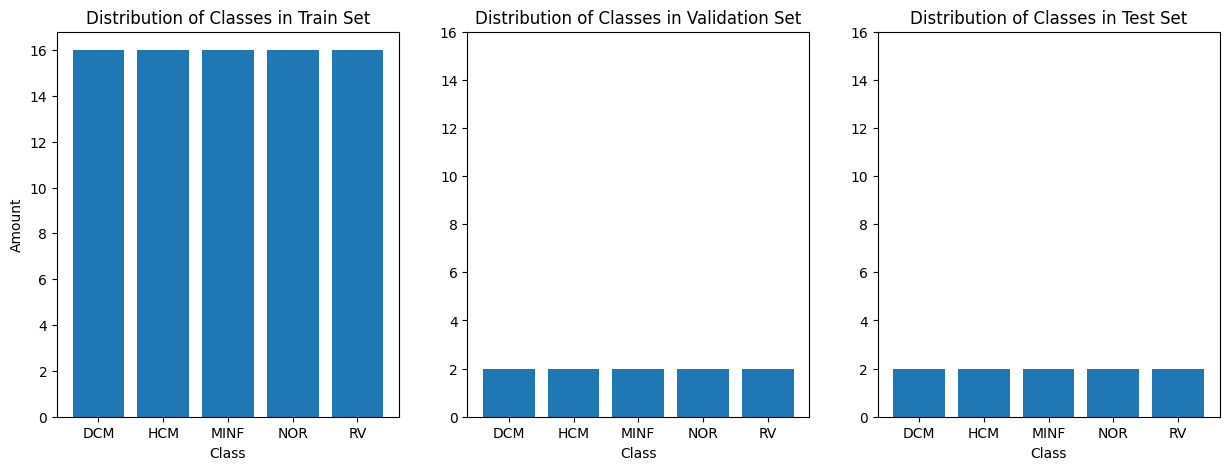

In [6]:
# Verify stratification worked and show sizes of the sets
fig, axs = plt.subplots(1, 3, figsize=(15,5))
classes = ["DCM","HCM","MINF", "NOR", "RV"]
axs[0].bar(classes, [y_train.count(i) for i in [0,1,2,3,4]])
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Amount")
axs[0].set_title("Distribution of Classes in Train Set")

axs[1].bar(classes, [y_val.count(i) for i in [0,1,2,3,4]])
axs[1].set_xlabel("Class")
axs[1].set_ylim(0,16)
axs[1].set_title("Distribution of Classes in Validation Set")

axs[2].bar(classes, [y_test.count(i) for i in [0,1,2,3,4]])
axs[2].set_xlabel("Class")
axs[2].set_ylim(0,16)
axs[2].set_title("Distribution of Classes in Test Set")
plt.show()

In [7]:
# Now save actual image_paths in the sets instead of patient ids
all_imgs = os.listdir('all')[::2] # Every second one is an image and every other a mask
train_X = []
val_X = []
test_X = []
for img_path in all_imgs:
    patient_id = int(re.search(r"patient(\d+)__", img_path).group(1)) # Get id of patient from filename
    if patient_id in X_train: # If the patient id of the current image path is in the train set, the image gets also added to the train set
        train_X.append(img_path)
    if patient_id in X_val:
        val_X.append(img_path)
    if patient_id in X_test:
        test_X.append(img_path)

## Defining Custom Dataset
It allows for easier management of how the images and masks are loaded and given to the model.
Only image paths have to be provided, it also gets the masks from that.
Make the masks only keep one class vor the left ventricle.
And augment images when the model needs an image. Every epoch each image is therefore augmented differently.

In [8]:
class CustomDataset(Dataset):
    def __init__(self, filenames, transform=None, transform_mask=None, return_pid=False):
        self.filenames = filenames
        self.transform = transform
        self.transform_mask = transform_mask
        self.return_pid = return_pid

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]

        # Load your data here, assuming it's an image for example
        image, _ = nrrd.read('all/'+filename)
        mask, _ = nrrd.read('all/'+filename.replace("img","msk")) # Load corresponding mask
        pid = int(re.search(r"patient(\d+)__", filename).group(1)) # Get pid of current patient
        mask[(mask==1) | (mask==2)] = 0 # Set other classes to 0
        mask[mask==3] = 255 # Make pixels for the LV class white
        image = image.astype("float32")

        # Apply transformations if any
        if self.transform:
            seed = random.randint(0, 2 ** 32) # Generate seed
            torch.manual_seed(seed) # Set seed for image transformation
            image = self.transform(image)
            torch.manual_seed(seed) # Set same seed for mask transformation so it gets transformed in the same random way as the corresponding image
            mask = self.transform_mask(mask)
        if self.return_pid:
            return image, mask, pid
        else:
            return image, mask


# 3. Image Augmentation

In [9]:
def MinMaxNormalizer(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())

def Binarize(tensor):
    tensor[tensor>0.5] = 1
    tensor[tensor<=0.5] = 0
    return tensor

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.GaussianBlur(5),
    transforms.RandomRotation(180), # First rotate then crop to remove black corners introduced by rotating the image
    # Images will have 256x256 resoulution. Most of the images are smaller than that and only some larger. Reduces training time when smaller
    transforms.RandomResizedCrop(256, scale=(0.75, 1)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    MinMaxNormalizer
])
transform_mask_train = transforms.Compose([ # Same transformations for the mask but without scaling
    transforms.ToPILImage(),
    transforms.GaussianBlur(5,sigma=(0.00001,0.000011)), # This has to be here. Otherwise, the mask is offset to the image somehow.
    transforms.RandomRotation(180),
    transforms.RandomResizedCrop(256, scale=(0.75, 1)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    Binarize
])

transform_test = transforms.Compose([ # Same transformations for the test images but without reducing information
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    MinMaxNormalizer
])
transform_mask_test = transforms.Compose([# Same as for test images but without normalizing
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    Binarize
])

In [10]:
image, _ = nrrd.read('all/patient027__t11_z4_img.nrrd')
image = image.astype("float32")

seed = random.randint(0, 2 ** 32) # Generate seed
torch.manual_seed(seed) # Set seed for image transformation
image = transform_train(image)

In [11]:
# Create Dataset objects and apply transformations to them. Data will be provided in batches to the trainer by the DataLoader.
generator = torch.Generator().manual_seed(1)
train_set = CustomDataset(train_X, transform=transform_train, transform_mask=transform_mask_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, generator=generator)
val_set = CustomDataset(val_X, transform=transform_test, transform_mask=transform_mask_test)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, generator=generator)
test_set = CustomDataset(test_X, transform=transform_test, transform_mask=transform_mask_test, return_pid=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, generator=generator)

### Plotting augmented images

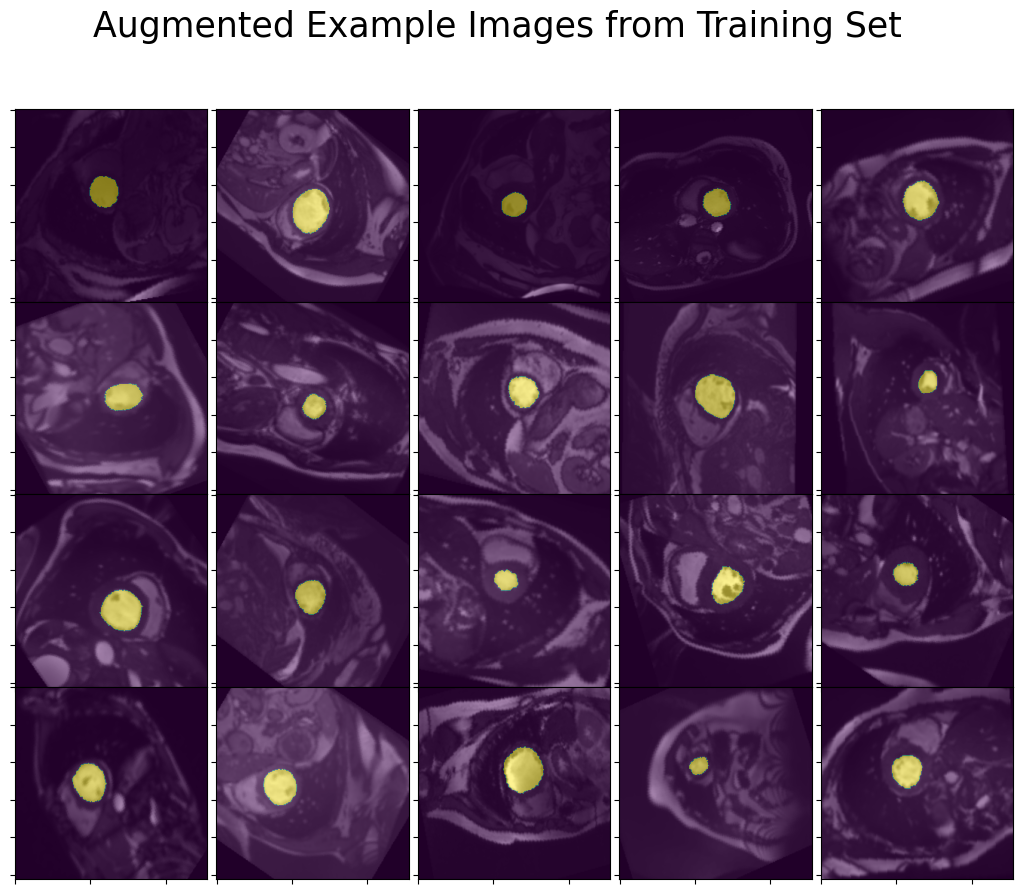

In [12]:
figs, axs = plt.subplots(4,5, figsize=(13, 10))
figs.subplots_adjust(wspace=0, hspace=0)
axs=axs.flatten()
counter = 0
for inputs, mask in train_loader:
    if counter < 20:
        for j in range(len(inputs)):
            if counter < 20: # Plot 20 random images only
                img = np.array(inputs[j].permute(1, 2, 0))
                if img.max() - img.min() != 0:
                    img = (img - img.min()) / (img.max() - img.min())
                axs[counter].imshow(img, cmap=plt.get_cmap('gray'))
                msk = np.array(mask[j].permute(1, 2, 0))
                if msk.max() - msk.min() != 0:
                    msk = (msk - msk.min()) / (msk.max() - msk.min())
                axs[counter].imshow(msk, alpha=.5, )
                counter += 1
            else:
                break
    else:
        break
for ax in axs:
    ax.grid(False)
    ax.tick_params(labelbottom=False, labelleft=False)
plt.suptitle("Augmented Example Images from Training Set", fontsize=25)
plt.show()

# 4/5. Implementing and Training U-Net (2D)

In [13]:
def plot_example(image, mask, output): # Plotting function to visually compare the true mask to the predicted one
    image, mask, output = image.to("cpu"), mask.to("cpu"), output.to("cpu")
    figs, axs = plt.subplots(1,2, figsize=(8, 4))
    axs = axs.flatten()
    
    # Plot images 
    for k in range(2):
        img = np.array(image.permute(1, 2, 0))
        if img.max() - img.min() != 0:
            img = (img - img.min()) / (img.max() - img.min())
        axs[k].imshow(img, cmap=plt.get_cmap('gray'))
    
    # Plot true mask 
    msk = np.array(mask.permute(1, 2, 0))
    if msk.max() - msk.min() != 0:
        msk = (msk - msk.min()) / (msk.max() - msk.min())
    axs[0].imshow(msk, alpha=.5, )
    axs[0].set_title("True")
    
    # Plot predicted mask 
    pred = np.array(output.permute(1, 2, 0))
    if pred.max() - pred.min() != 0:
        pred = (pred - pred.min()) / (pred.max() - pred.min())
    axs[1].imshow(pred, alpha=.5, )
    axs[1].set_title(f"Predicted (BCELoss {get_loss(output, mask):.4f})")
    for ax in axs:
        ax.grid(False)
        ax.tick_params(labelbottom=False, labelleft=False)
    plt.show()

In [14]:
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 64, 3)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.conv2 = torch.nn.Conv2d(64, 64, 3)
        self.bn2 = torch.nn.BatchNorm2d(64)
        
        self.conv3 = torch.nn.Conv2d(64, 128, 3)
        self.bn3 = torch.nn.BatchNorm2d(128)
        self.conv4 = torch.nn.Conv2d(128, 128, 3)
        self.bn4 = torch.nn.BatchNorm2d(128)
        
        self.conv5 = torch.nn.Conv2d(128, 256, 3)
        self.bn5 = torch.nn.BatchNorm2d(256)
        self.conv6 = torch.nn.Conv2d(256, 256, 3)
        self.bn6 = torch.nn.BatchNorm2d(256)
        
        self.conv7 = torch.nn.Conv2d(256, 512, 3)
        self.bn7 = torch.nn.BatchNorm2d(512)
        self.conv8 = torch.nn.Conv2d(512, 512, 3)
        self.bn8 = torch.nn.BatchNorm2d(512)
        
        self.conv9 = torch.nn.Conv2d(512, 1024, 3)
        self.bn9 = torch.nn.BatchNorm2d(1024)
        self.conv10 = torch.nn.Conv2d(1024, 1024, 3)
        self.bn10 = torch.nn.BatchNorm2d(1024)
        
        self.upconv1 = torch.nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv_dc1 = torch.nn.Conv2d(1024, 512, 3)
        self.bn_dc1 = torch.nn.BatchNorm2d(512)
        self.conv_dc2 = torch.nn.Conv2d(512, 512, 3)
        self.bn_dc2 = torch.nn.BatchNorm2d(512)
        
        self.upconv2 = torch.nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv_dc3 = torch.nn.Conv2d(512, 256, 3)
        self.bn_dc3 = torch.nn.BatchNorm2d(256)
        self.conv_dc4 = torch.nn.Conv2d(256, 256, 3)
        self.bn_dc4 = torch.nn.BatchNorm2d(256)
        
        self.upconv3 = torch.nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv_dc5 = torch.nn.Conv2d(256, 128, 3)
        self.bn_dc5 = torch.nn.BatchNorm2d(128)
        self.conv_dc6 = torch.nn.Conv2d(128, 128, 3)
        self.bn_dc6 = torch.nn.BatchNorm2d(128)
        
        self.upconv4 = torch.nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv_dc7 = torch.nn.Conv2d(128, 64, 3)
        self.bn_dc7 = torch.nn.BatchNorm2d(64)
        self.conv_dc8 = torch.nn.Conv2d(64, 64, 3)
        self.bn_dc8 = torch.nn.BatchNorm2d(64)
        
        self.final_conv = torch.nn.Conv2d(64, 1, 1)
        

    def forward(self, x):
        encoder1 = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))
        encoder2 = F.max_pool2d(F.relu(self.bn4(self.conv4(F.relu(self.bn3(self.conv3(encoder1)))))), (2,2), stride=2)
        encoder3 = F.max_pool2d(F.relu(self.bn6(self.conv6(F.relu(self.bn5(self.conv5(encoder2)))))), (2,2), stride=2)
        encoder4 = F.max_pool2d(F.relu(self.bn8(self.conv8(F.relu(self.bn7(self.conv7(encoder3)))))), (2,2), stride=2)
        # 4 encoder/decoder steps seem to be optimal. The initial paper used 5 but their images where twice the size. The one maxpooling layer less outweighs that.
        #encoder5 = F.max_pool2d(F.relu(self.bn10(self.conv10(F.relu(self.bn9(self.conv9(encoder4)))))), (2,2), stride=2)
        
        #upconv = self.upconv1(encoder5)
        #decoder1 = F.relu(self.bn_dc2(self.conv_dc2(F.relu(self.bn_dc1(self.conv_dc1(torch.cat([transforms.CenterCrop(upconv.size()[2:])(encoder4), upconv], dim=1)))))))
        
        upconv = self.upconv2(encoder4)
        decoder2 = F.relu(self.bn_dc4(self.conv_dc4(F.relu(self.bn_dc3(self.conv_dc3(torch.cat([transforms.CenterCrop(upconv.size()[2:])(encoder3), upconv], dim=1)))))))
        
        upconv = self.upconv3(decoder2)
        decoder3 = F.relu(self.bn_dc6(self.conv_dc6(F.relu(self.bn_dc5(self.conv_dc5(torch.cat([transforms.CenterCrop(upconv.size()[2:])(encoder2), upconv], dim=1)))))))
        
        upconv = self.upconv4(decoder3)
        decoder4 = F.relu(self.bn_dc8(self.conv_dc8(F.relu(self.bn_dc7(self.conv_dc7(torch.cat([transforms.CenterCrop(upconv.size()[2:])(encoder1), upconv], dim=1)))))))
        
        return F.sigmoid(F.interpolate(self.final_conv(decoder4), size=x.size()[2:], mode="nearest"))


Epoch 1/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.08it/s, val_loss=0.116]


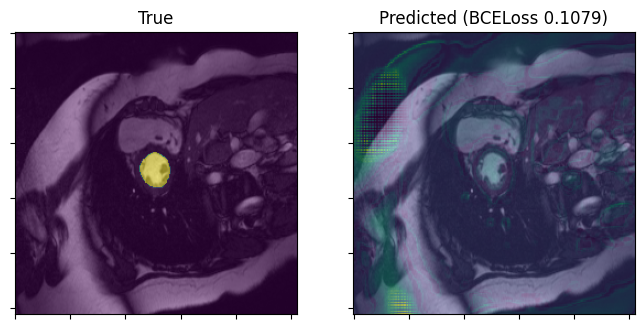

Epoch [1/100], Train Loss: 0.2336, Val Loss: 0.1076


Epoch 2/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.16it/s, val_loss=0.071]


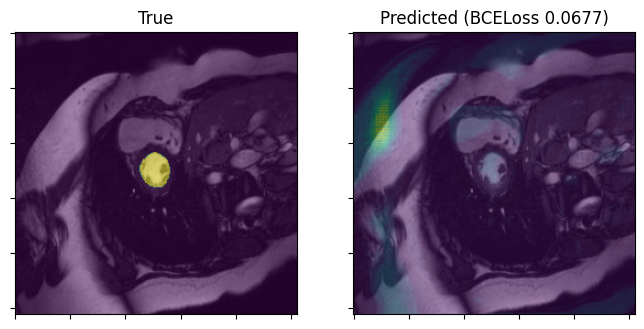

Epoch [2/100], Train Loss: 0.0883, Val Loss: 0.0662


Epoch 3/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.13it/s, val_loss=0.064] 


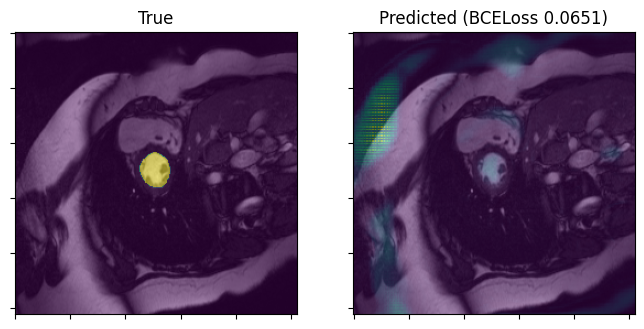

Epoch [3/100], Train Loss: 0.0676, Val Loss: 0.0596


Epoch 4/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.23it/s, val_loss=0.0642]


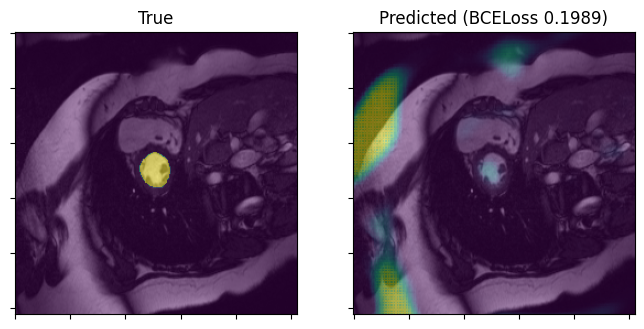

Epoch [4/100], Train Loss: 0.0590, Val Loss: 0.0598


Epoch 5/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.14it/s, val_loss=0.0589]


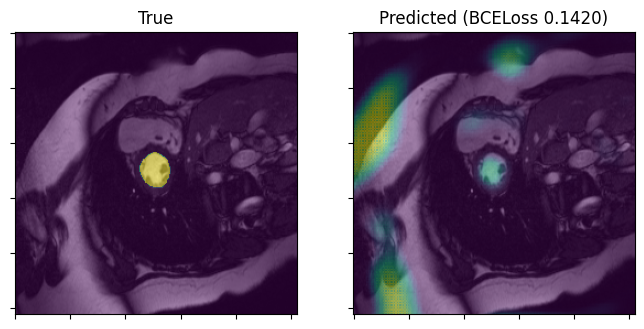

Epoch [5/100], Train Loss: 0.0531, Val Loss: 0.0549


Epoch 6/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.13it/s, val_loss=0.0543]


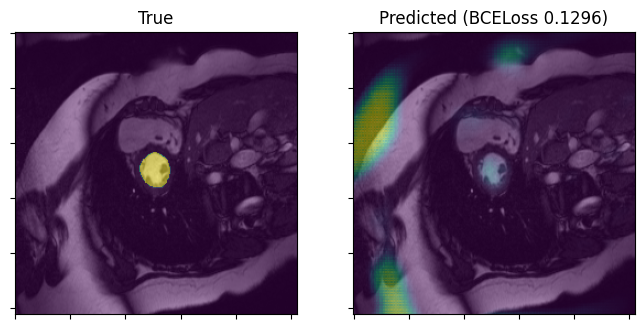

Epoch [6/100], Train Loss: 0.0481, Val Loss: 0.0506


Epoch 7/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.15it/s, val_loss=0.0586]


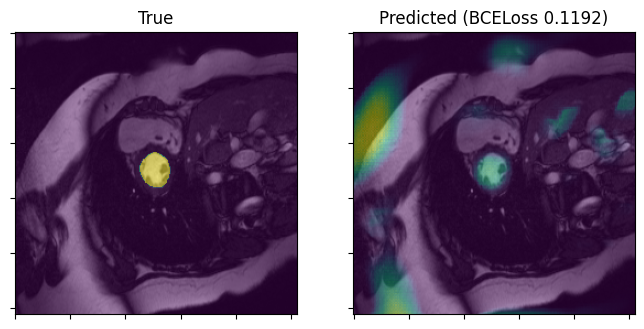

Epoch [7/100], Train Loss: 0.0442, Val Loss: 0.0546


Epoch 8/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.17it/s, val_loss=0.0347]


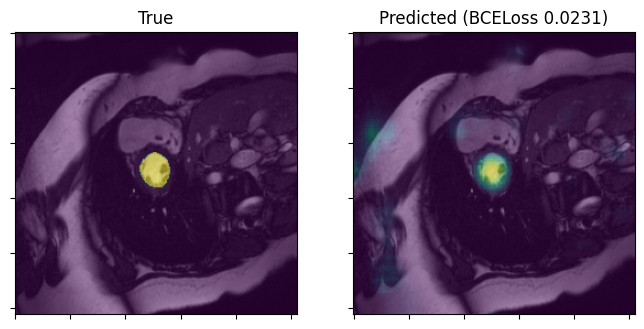

Epoch [8/100], Train Loss: 0.0398, Val Loss: 0.0323


Epoch 9/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.05it/s, val_loss=0.0436]


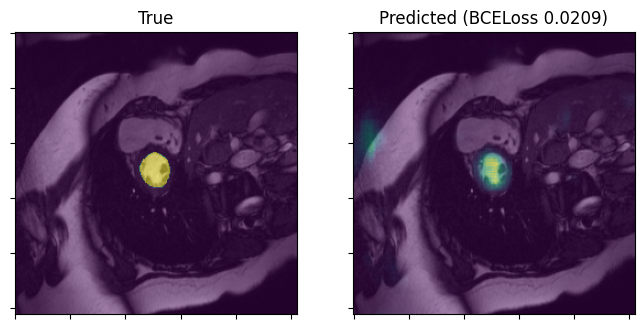

Epoch [9/100], Train Loss: 0.0359, Val Loss: 0.0406


Epoch 10/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.17it/s, val_loss=0.029] 


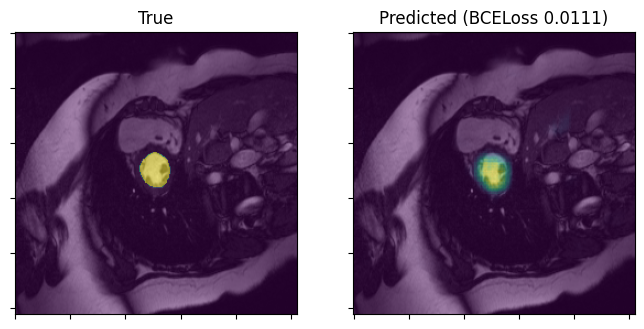

Epoch [10/100], Train Loss: 0.0310, Val Loss: 0.0270


Epoch 11/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.01it/s, val_loss=0.025] 


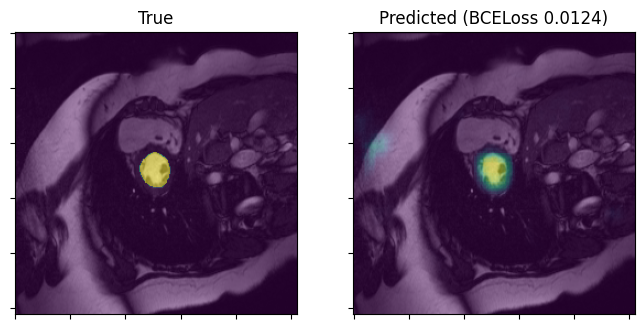

Epoch [11/100], Train Loss: 0.0290, Val Loss: 0.0233


Epoch 12/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.82it/s, val_loss=0.0234]


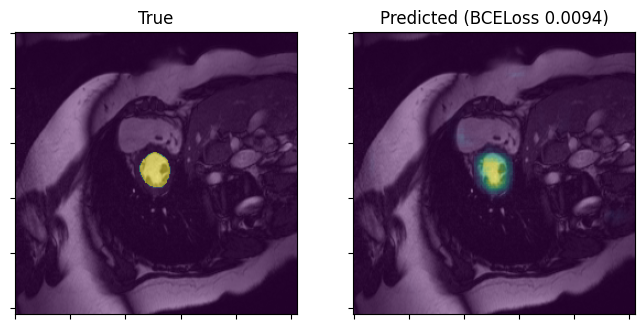

Epoch [12/100], Train Loss: 0.0267, Val Loss: 0.0218


Epoch 13/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.10it/s, val_loss=0.0218]


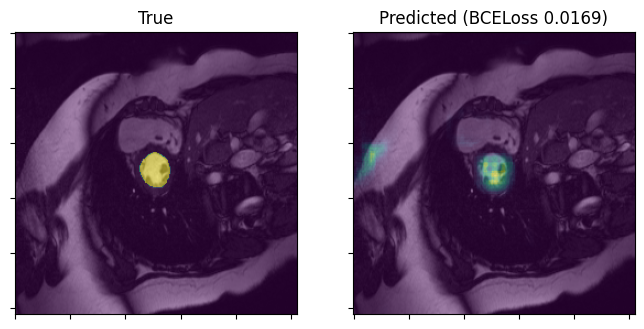

Epoch [13/100], Train Loss: 0.0253, Val Loss: 0.0203


Epoch 14/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.18it/s, val_loss=0.0241]


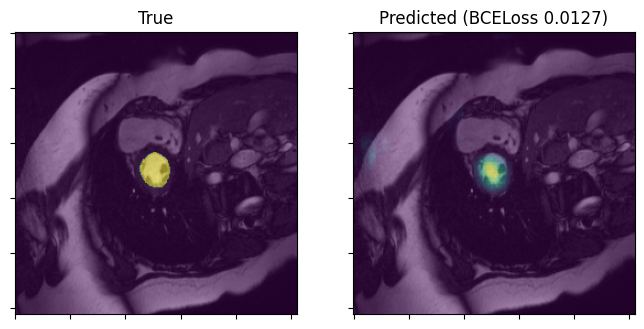

Epoch [14/100], Train Loss: 0.0241, Val Loss: 0.0225


Epoch 15/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.06it/s, val_loss=0.0184]


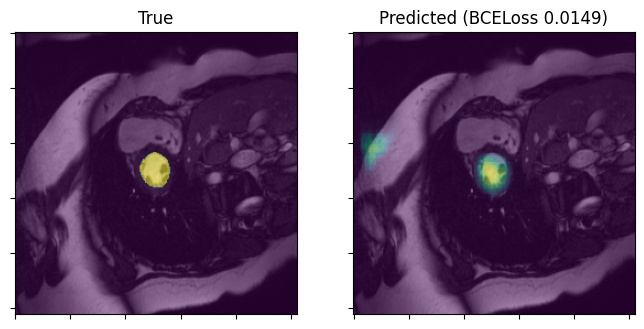

Epoch [15/100], Train Loss: 0.0229, Val Loss: 0.0171


Epoch 16/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.20it/s, val_loss=0.019] 


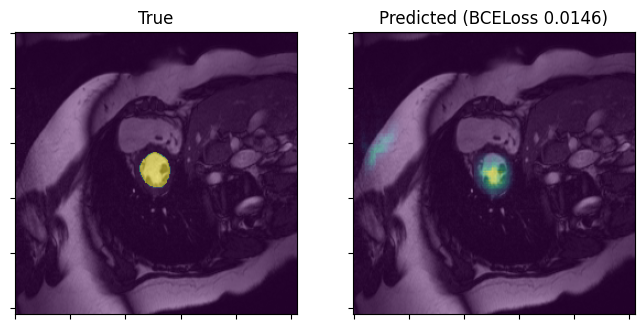

Epoch [16/100], Train Loss: 0.0218, Val Loss: 0.0177


Epoch 17/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.00it/s, val_loss=0.0169]


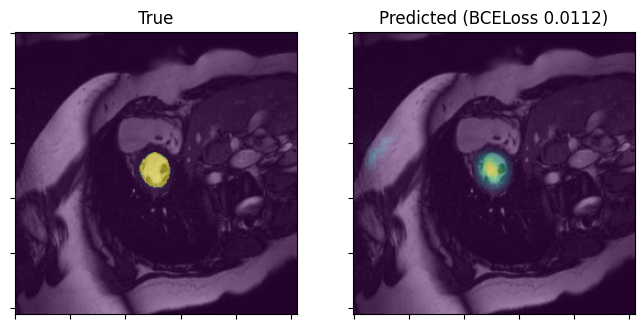

Epoch [17/100], Train Loss: 0.0214, Val Loss: 0.0157


Epoch 18/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  9.21it/s, val_loss=0.0201]


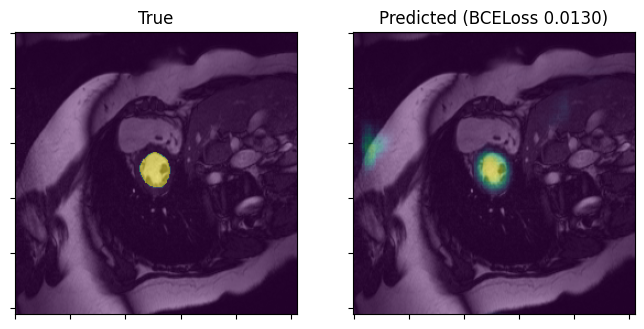

Epoch [18/100], Train Loss: 0.0220, Val Loss: 0.0187


Epoch 19/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.79it/s, val_loss=0.0201]


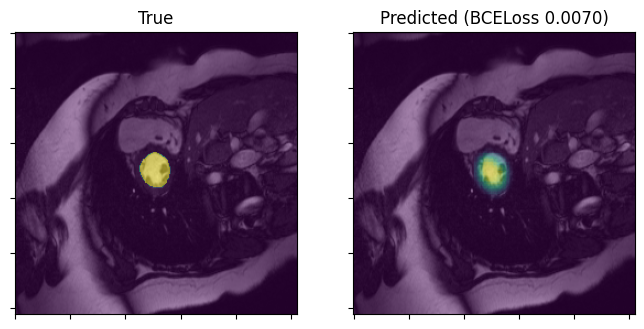

Epoch [19/100], Train Loss: 0.0210, Val Loss: 0.0187


Epoch 20/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.11it/s, val_loss=0.0178]


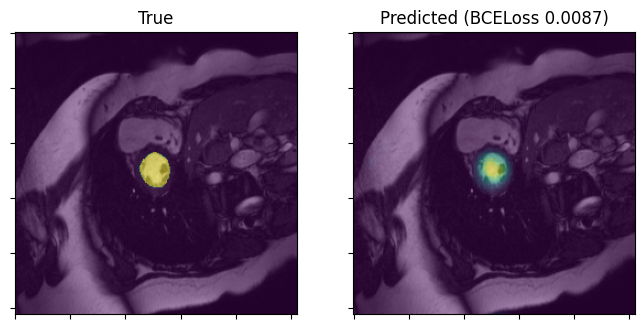

Epoch [20/100], Train Loss: 0.0211, Val Loss: 0.0166


Epoch 21/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.25it/s, val_loss=0.0156]


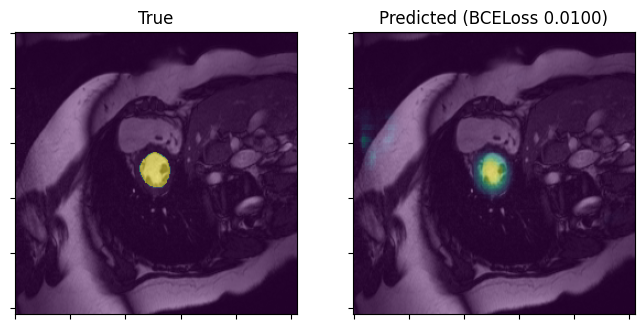

Epoch [21/100], Train Loss: 0.0198, Val Loss: 0.0146


Epoch 22/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.45it/s, val_loss=0.0176]


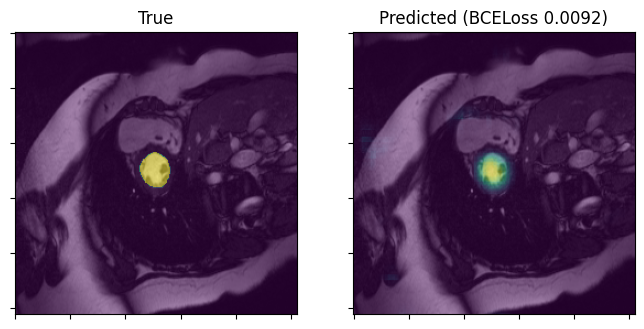

Epoch [22/100], Train Loss: 0.0204, Val Loss: 0.0164


Epoch 23/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.53it/s, val_loss=0.0158]


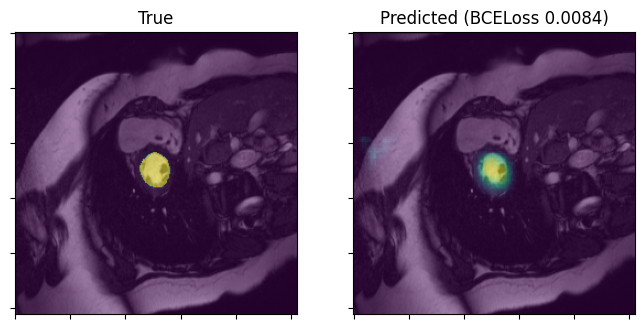

Epoch [23/100], Train Loss: 0.0196, Val Loss: 0.0148


Epoch 24/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.49it/s, val_loss=0.0192]


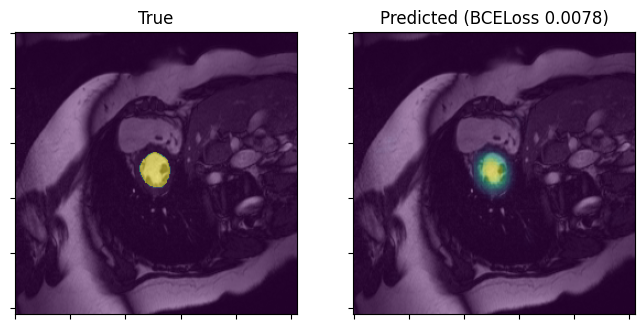

Epoch [24/100], Train Loss: 0.0200, Val Loss: 0.0179


Epoch 25/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.41it/s, val_loss=0.0157]


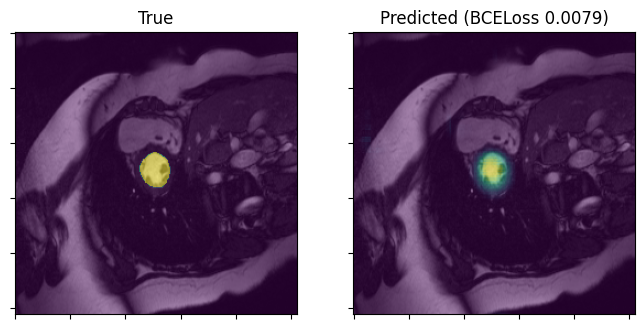

Epoch [25/100], Train Loss: 0.0192, Val Loss: 0.0146


Epoch 26/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.47it/s, val_loss=0.0136]


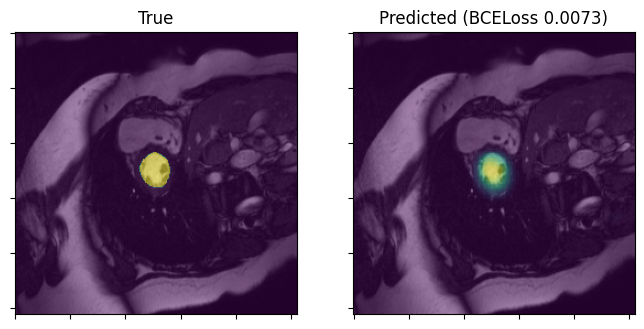

Epoch [26/100], Train Loss: 0.0179, Val Loss: 0.0127


Epoch 27/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.45it/s, val_loss=0.0141]


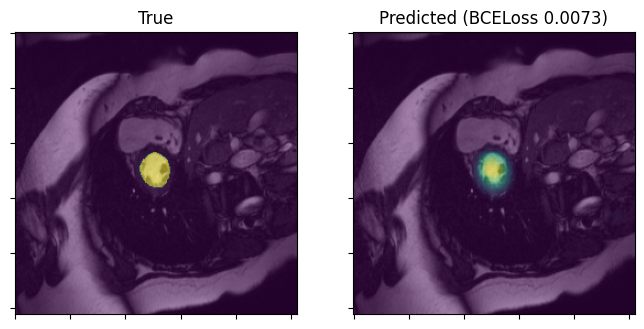

Epoch [27/100], Train Loss: 0.0178, Val Loss: 0.0132


Epoch 28/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.46it/s, val_loss=0.0135]


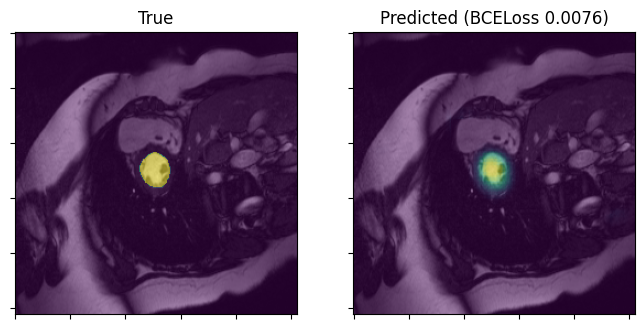

Epoch [28/100], Train Loss: 0.0173, Val Loss: 0.0126


Epoch 29/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.51it/s, val_loss=0.0139]


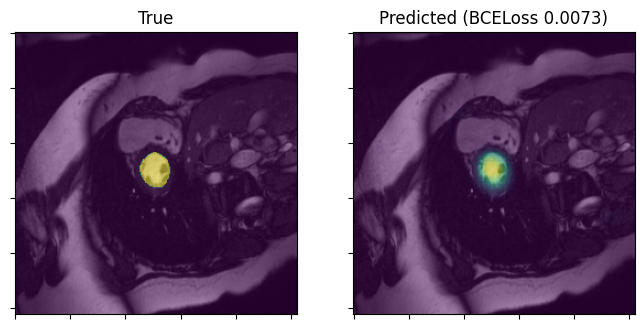

Epoch [29/100], Train Loss: 0.0174, Val Loss: 0.0129


Epoch 30/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.52it/s, val_loss=0.0138]


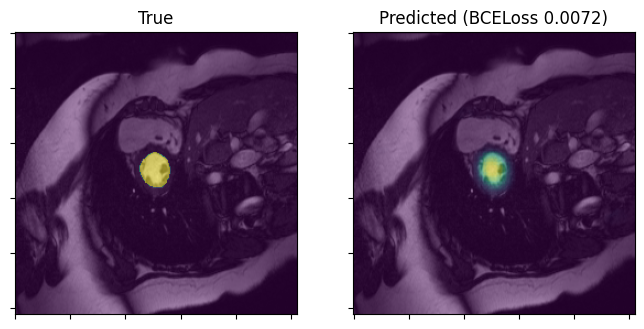

Epoch [30/100], Train Loss: 0.0171, Val Loss: 0.0129


Epoch 31/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.37it/s, val_loss=0.0133]


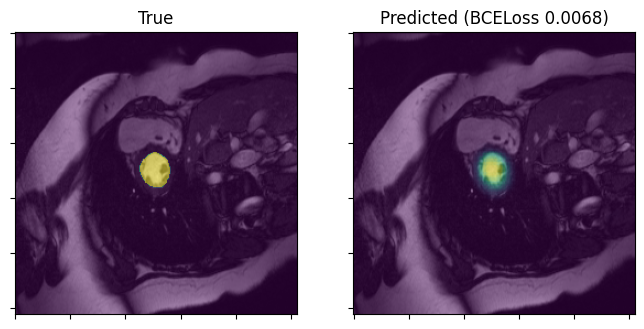

Epoch [31/100], Train Loss: 0.0169, Val Loss: 0.0124


Epoch 32/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.51it/s, val_loss=0.0135]


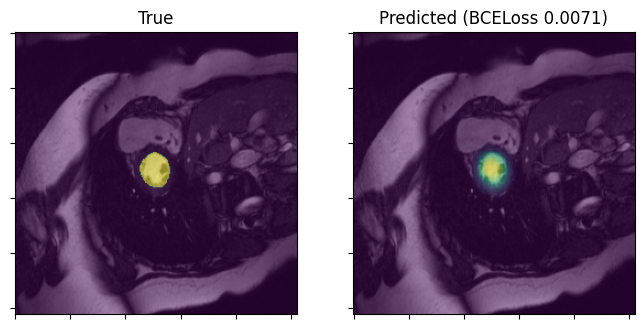

Epoch [32/100], Train Loss: 0.0169, Val Loss: 0.0126


Epoch 33/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.51it/s, val_loss=0.0131]


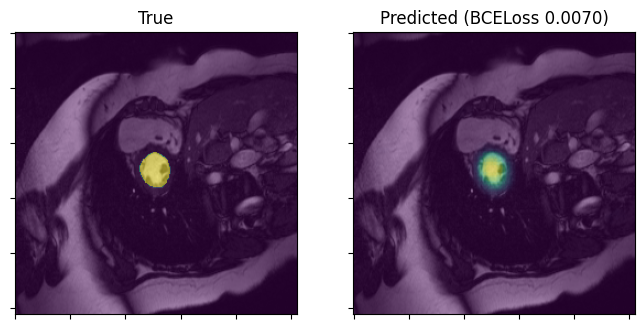

Epoch [33/100], Train Loss: 0.0169, Val Loss: 0.0122


Epoch 34/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.54it/s, val_loss=0.0135]


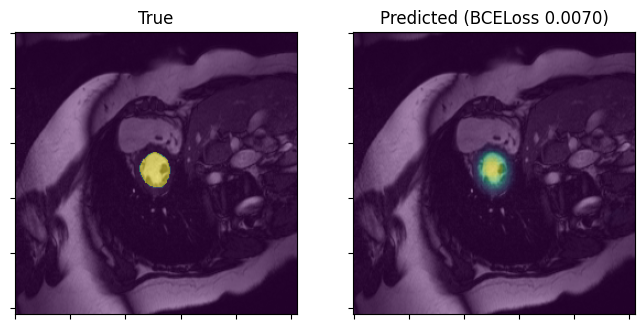

Epoch [34/100], Train Loss: 0.0169, Val Loss: 0.0126


Epoch 35/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.34it/s, val_loss=0.0135]


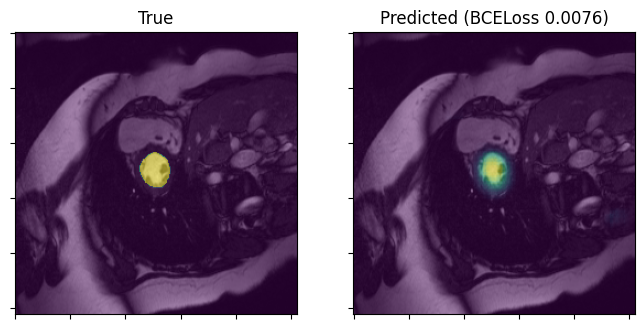

Epoch [35/100], Train Loss: 0.0170, Val Loss: 0.0125


Epoch 36/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.65it/s, val_loss=0.0143]


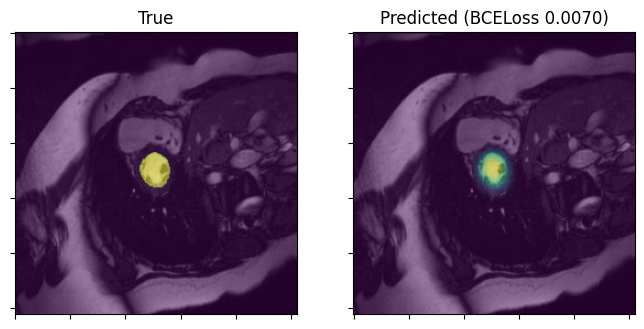

Epoch [36/100], Train Loss: 0.0167, Val Loss: 0.0133


Epoch 37/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.40it/s, val_loss=0.0133]


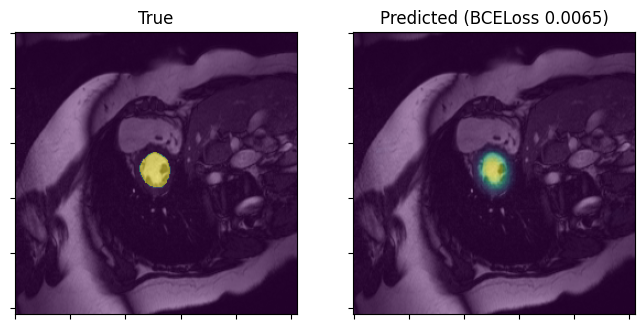

Epoch [37/100], Train Loss: 0.0170, Val Loss: 0.0124


Epoch 38/100, Validation: 100%|██████████| 12/12 [00:01<00:00,  8.90it/s, val_loss=0.0133]


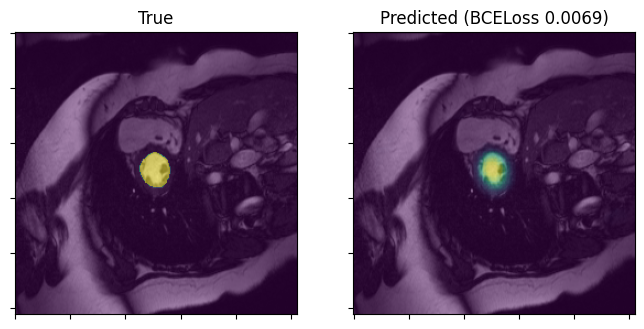

Epoch [38/100], Train Loss: 0.0166, Val Loss: 0.0124


In [15]:
model = UNet().to("cuda") # Create model and push it to the GPU

# Define loss function and optimizer
get_loss = nn.BCELoss() # Use Binary Crossentropy as loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

curr_patience = 0
train_losses = []
val_losses = []
if train: # Only train if this var is true. Otherwise the previous best model is loaded.
    # Training loop
    for epoch in range(max_num_epochs):
        model.train() # Set model to training state. So layers like dropout are active.
        train_loss = 0.0
        val_loss = 0.0
        # Training
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{max_num_epochs}, Training')
        
        for i, (images, masks) in enumerate(progress_bar): # Iterate over batches
            images, masks = images.to("cuda"), masks.to("cuda") # Pus data to GPU
            optimizer.zero_grad() # Resetting gradients
            outputs = model(images) # Forward pass
            loss = get_loss(outputs, masks) # Calculate loss
            loss.backward() # Backpropagation
            optimizer.step() # Make one step towards the optimal direction
    
            train_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(train_loss=train_loss / ((i*batch_size)+1))
    
        # Validation
        model.eval()  # Set model to validation state. So layers like dropout are inactive.
        with torch.no_grad(): # Do not compute gradients in the layers to increase speed as these are not needed for validation.
            progress_bar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{max_num_epochs}, Validation')
            for i, (images, masks) in enumerate(progress_bar):
                images, masks = images.to("cuda"), masks.to("cuda")
                outputs = model(images) # Forward pass
                loss = get_loss(outputs, masks) # Only compute Loss. Nothing else.
    
                val_loss += loss.item() * images.size(0)
                progress_bar.set_postfix(val_loss=val_loss / ((i*batch_size)+1))
            
            plot_example(images[1], masks[1], outputs[1]) # Plot one example image per epoch
            
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        
        print(f'Epoch [{epoch+1}/{max_num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        if np.any(val_loss >= np.array(val_losses)): # Early stopping. Save model with best validation.
            curr_patience += 1
        else:
            curr_patience = 0
            torch.save(model, "best_model.pth")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if curr_patience == early_stopping_patience - 1:
            learning_rate /= 10
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        if curr_patience == early_stopping_patience:
            break
model = torch.load("best_model.pth") # Load model with best validation

#### Plotting Training History

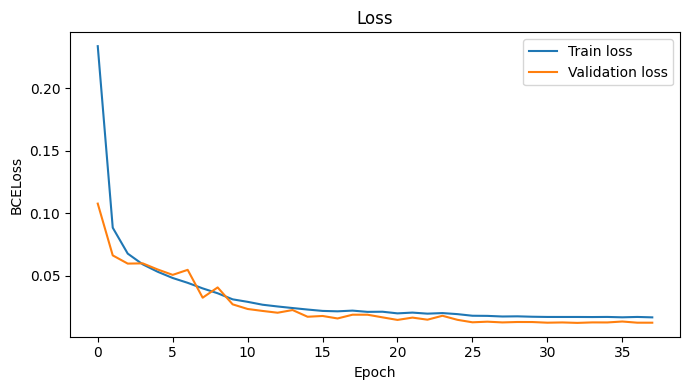

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(7, 4))
axs.set_title("Loss")
history = [train_losses, val_losses]
for i, (set, metric) in enumerate([["Train", "loss"], ["Validation", "loss"]]):
    if len(history[i]) > 0:
        axs.plot(history[i], label=f"{set} {metric}")
    axs.set_xlabel("Epoch")
    axs.set_ylabel("BCELoss")
    axs.legend()
plt.tight_layout()
plt.show()

# 6/7. Testing

Train: 100%|██████████| 95/95 [00:13<00:00,  7.16it/s, loss=0.017] 


Train Loss: 0.0169
Train Mean Dice Coefficient: 0.5389 ± 0.2544


Validation: 100%|██████████| 12/12 [00:01<00:00,  8.87it/s, loss=0.0131]


Validation Loss: 0.0122
Validation Mean Dice Coefficient: 0.5472 ± 0.2682


Test:   0%|          | 0/13 [00:00<?, ?it/s, loss=0.327]

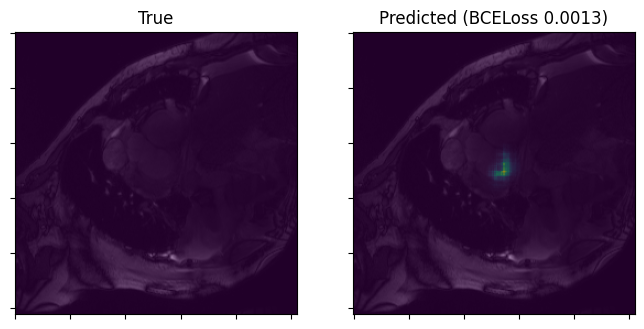

Test:   8%|▊         | 1/13 [00:00<00:02,  4.16it/s, loss=0.0308]

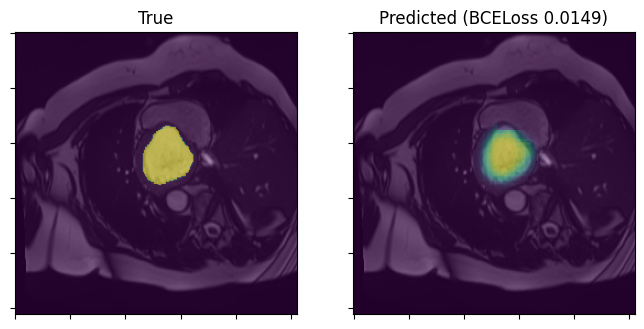

Test:  15%|█▌        | 2/13 [00:00<00:02,  3.97it/s, loss=0.0213]

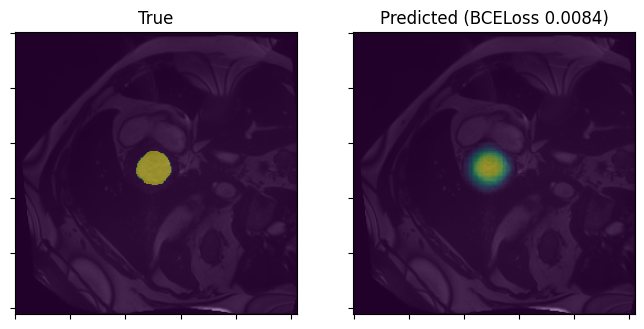

Test:  23%|██▎       | 3/13 [00:00<00:02,  3.98it/s, loss=0.0159]

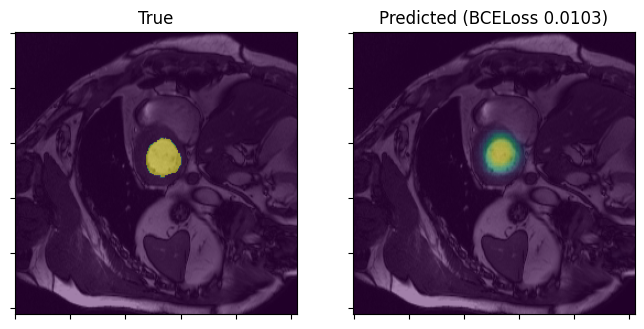

Test:  38%|███▊      | 5/13 [00:01<00:01,  4.88it/s, loss=0.014] 

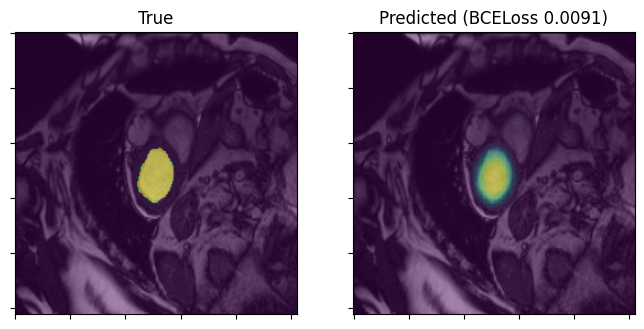

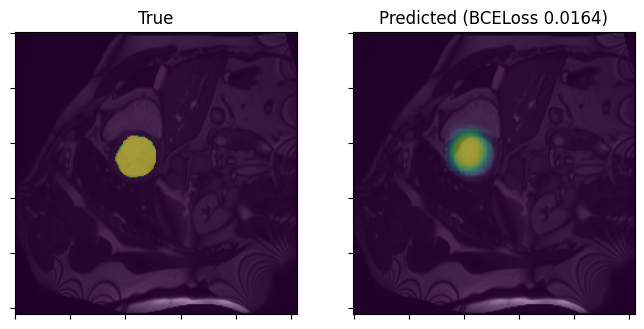

Test:  46%|████▌     | 6/13 [00:01<00:01,  3.71it/s, loss=0.0137]

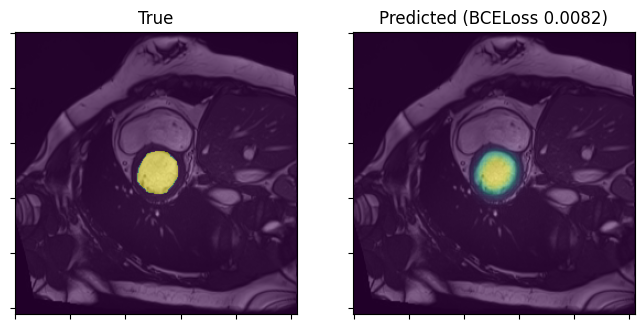

Test:  54%|█████▍    | 7/13 [00:01<00:01,  3.68it/s, loss=0.0129]

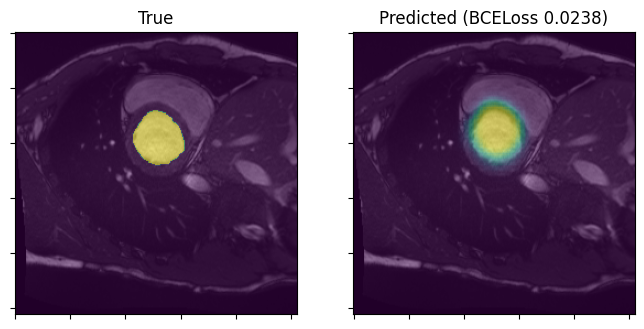

Test:  62%|██████▏   | 8/13 [00:02<00:01,  3.63it/s, loss=0.0133]

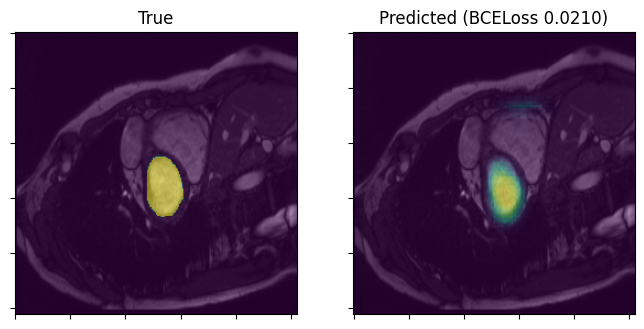

Test:  77%|███████▋  | 10/13 [00:02<00:00,  4.49it/s, loss=0.0145]

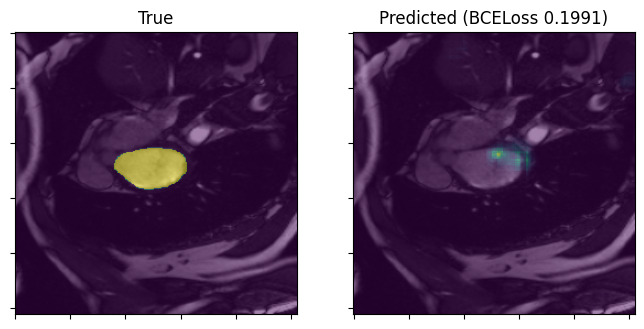

Test: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s, loss=0.0165]

Test Loss: 0.0156
Test Mean Dice Coefficient: 0.5085 ± 0.2705


In [25]:
def dice_coefficient(outputs, masks):
    intersection = torch.sum(outputs * masks)
    union = torch.sum(outputs) + torch.sum(masks)
    if union == 0:
        return 1.0
    dice = (2. * intersection) / union
    return dice.item()

# Validation
model.eval()
for set_type, loader in [("Train", train_loader), ("Validation", val_loader), ("Test", test_loader)]:
    test_loss = 0.0
    displayed_patients = []
    dice_scores = []
    with torch.no_grad():
        progress_bar = tqdm(loader, desc=f'{set_type}')
        for i, data in enumerate(progress_bar):
            if set_type == "Test":
                images, masks, pids = data
            else:
                images, masks = data
            images, masks = images.to("cuda"), masks.to("cuda")
            outputs = model(images)
            loss = get_loss(outputs, masks)
    
            test_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(loss=test_loss / ((i*batch_size)+1))
            
            dice_batch = []
            for j in range(len(images)):
                dice_score = dice_coefficient(outputs[j], masks[j])
                dice_batch.append(dice_score)
            dice_scores.extend(dice_batch)
            
            if set_type == "Test":
                for j, pid in enumerate(pids):
                    if pid not in displayed_patients:
                        displayed_patients.append(pid)
                        plot_example(images[j], masks[j], outputs[j])
            
    test_loss /= len(loader.dataset)
    mean_dice = sum(dice_scores) / len(dice_scores)
    std_dice = torch.std(torch.tensor(dice_scores))
    print(f'{set_type} Loss: {test_loss:.4f}')
    print(f'{set_type} Mean Dice Coefficient: {mean_dice:.4f} ± {std_dice:.4f}')

In [18]:
# Handle test data
# Data from https://humanheart-project.creatis.insa-lyon.fr/database/#collection/637218c173e9f0047faa00fb/folder/637218e573e9f0047faa00fc
if os.path.exists(f"testing/MANDATORY_CITATION.md"):
    def unzip(zipped_file):
        with gzip.open(zipped_file, 'rb') as f_in:
            with open(zipped_file.replace(".gz",""), 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        # Delete the original .gz file
        os.remove(zipped_file)
    os.remove(f"testing/MANDATORY_CITATION.md")
    for patient in os.listdir("testing"):
        os.remove(f"testing/{patient}/Info.cfg")
        os.remove(f"testing/{patient}/MANDATORY_CITATION.md")
        os.remove(f"testing/{patient}/{patient}_4d.nii.gz")
    for patient in os.listdir("testing"):
        for file in os.listdir(f"testing/{patient}"):
            unzip(f"testing/{patient}/{file}")

In [19]:
#Open data and save in batches. The CustomDataset from before cannot be used as the data is in completely different format
imgs_test = []
masks_test = []
for patient in os.listdir("testing"):
    for file in os.listdir(f"testing/{patient}"):
        if "gt" in file:
            mask = nib.load(f"testing/{patient}/{file}").get_fdata().astype("float32")
            mask[(mask==1) | (mask==2)] = 0
            mask[mask==3] = 1
            for i in range(mask.shape[2]):
                masks_test.append(transform_mask_test(mask[:,:,i:i+1]))
        else:
            img = nib.load(f"testing/{patient}/{file}").get_fdata().astype("float32")
            for i in range(img.shape[2]):
                imgs_test.append(transform_test(img[:,:,i:i+1]))
imgs_test = torch.stack(imgs_test)
masks_test = torch.stack(masks_test)
# Calculate the number of batches and the size of the last batch
num_batches = len(imgs_test) // batch_size
last_batch_size = len(imgs_test) % batch_size

# Create batches
batches_img = []
batches_msk= []
for i in range(num_batches):
    batch_img = imgs_test[i * batch_size: (i + 1) * batch_size]
    batch_msk = masks_test[i * batch_size: (i + 1) * batch_size]
    batches_img.append(batch_img)
    batches_msk.append(batch_msk)

# Add the last batch if it's not empty
if last_batch_size > 0:
    last_batch_img = imgs_test[num_batches * batch_size:]
    last_batch_msk = masks_test[num_batches * batch_size:]
    batches_img.append(last_batch_img)
    batches_msk.append(last_batch_msk)

Test: 0it [00:00, ?it/s, val_loss=0.135]

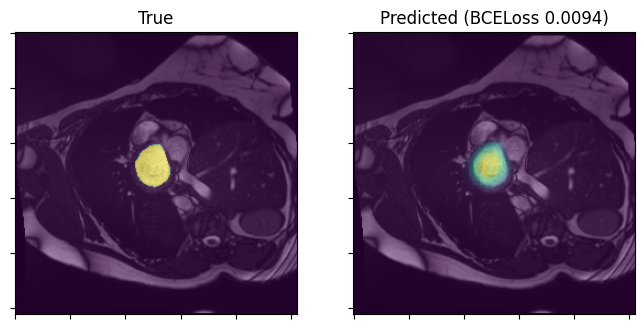

Test: 19it [00:02, 11.39it/s, val_loss=0.0165]

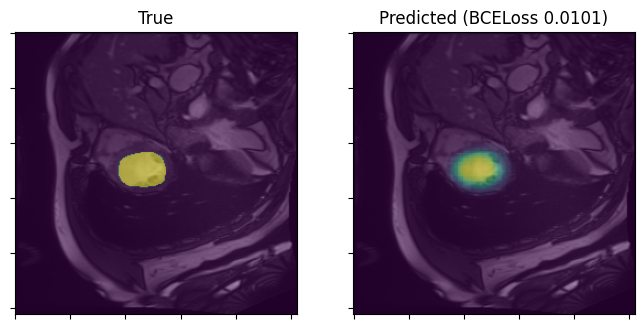

Test: 39it [00:04, 11.62it/s, val_loss=0.0148]

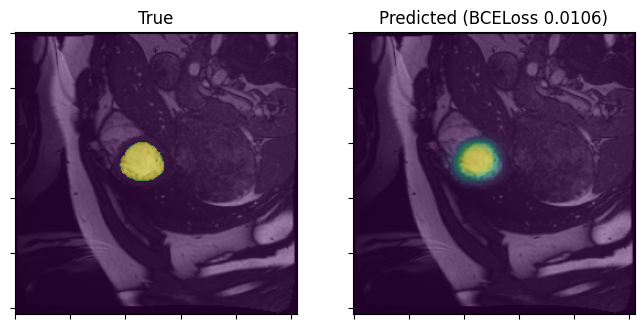

Test: 59it [00:05, 11.59it/s, val_loss=0.0142]

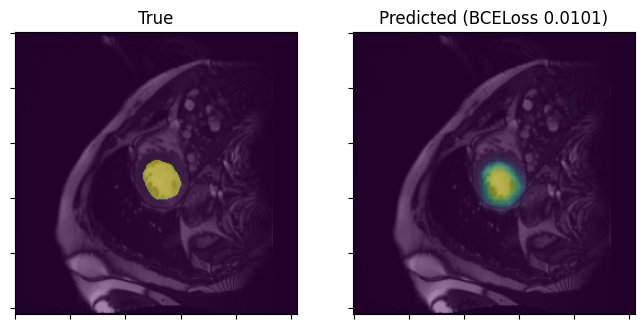

Test: 68it [00:06, 10.29it/s, val_loss=0.0136]

Test Loss: 0.0717
Mean Dice Coefficient: 0.5009 ± 0.2736


In [20]:
# Testing
model.eval()
model = model.to("cuda")
test_loss = 0.0
displayed_patients = []
dice_scores = []
with torch.no_grad():
    progress_bar = tqdm(zip(batches_img, batches_msk), desc=f'Test')
    for i, (images, masks) in enumerate(progress_bar):
        images, masks = images.to("cuda"), masks.to("cuda")
        outputs = model(images)
        loss = get_loss(outputs, masks)
        
        test_loss += loss.item() * images.size(0)
        progress_bar.set_postfix(val_loss=test_loss / ((i*batch_size)+1))
        
        dice_batch = []
        for j in range(len(images)):
            dice_score = dice_coefficient(outputs[j], masks[j])
            dice_batch.append(dice_score)
        dice_scores.extend(dice_batch)
        
        if i%20==0:
            plot_example(images[0], masks[0], outputs[0])
        
test_loss /= len(test_loader.dataset)
mean_dice = sum(dice_scores) / len(dice_scores)
std_dice = torch.std(torch.tensor(dice_scores))
print(f'Test Loss: {test_loss:.4f}')
print(f'Mean Dice Coefficient: {mean_dice:.4f} ± {std_dice:.4f}')

# 8. Optimization
Before, the segmentations did not have a clear edge and are mostly gaussian distributed over the correct region. Now we test different thresholds for making the predictions binary. Meaning if a predicted value is above the threshold, it is set to 1 and 0 otherwise. This also prevents the model to draw arbitrary segments when in reality the left ventricle is not visible on the image. This will increase the loss as the model is optimized for the best loss, but the DICE-Coefficient will improve.

Test:   0%|          | 0/13 [00:00<?, ?it/s, val_loss=10.3]

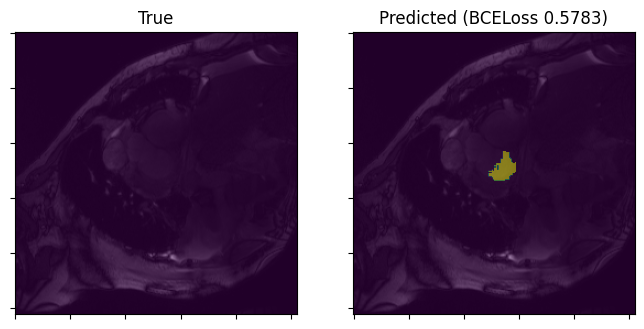

Test:   8%|▊         | 1/13 [00:00<00:04,  2.56it/s, val_loss=2.08]

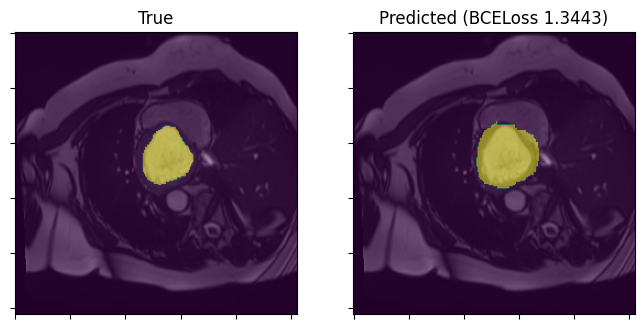

Test:  15%|█▌        | 2/13 [00:00<00:03,  3.31it/s, val_loss=2.03]

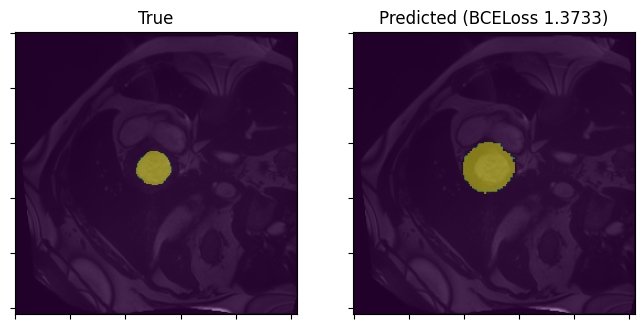

Test: 100%|██████████| 13/13 [00:02<00:00,  6.49it/s, val_loss=1.27]


Threshold : 0.05    Test Loss: 1.2002
Threshold : 0.05    Mean Dice Coefficient: 0.5648 ± 0.2491


Test:   0%|          | 0/13 [00:00<?, ?it/s, val_loss=8.03]

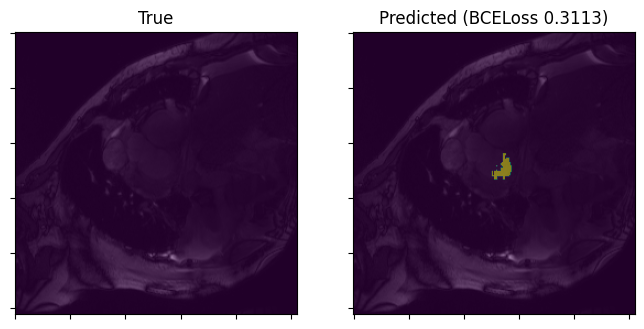

Test:   8%|▊         | 1/13 [00:00<00:02,  4.03it/s, val_loss=1.46]

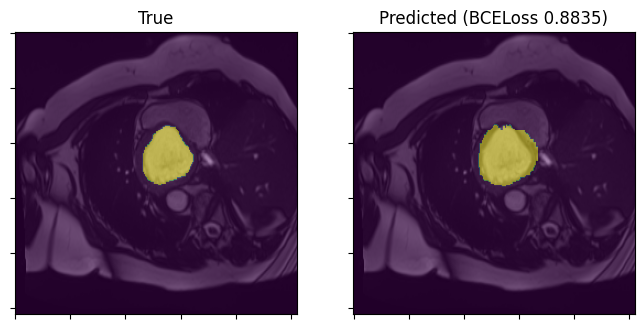

Test:  15%|█▌        | 2/13 [00:00<00:02,  4.08it/s, val_loss=1.42]

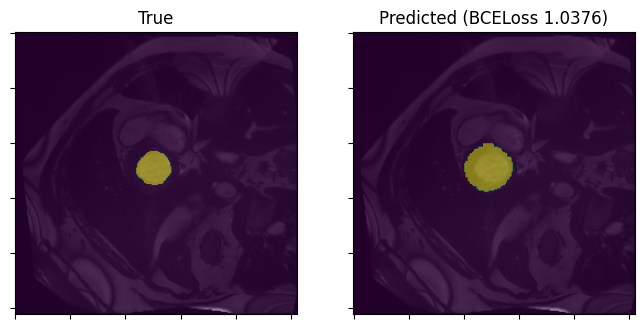

Test: 100%|██████████| 13/13 [00:01<00:00,  6.93it/s, val_loss=0.912]


Threshold : 0.1    Test Loss: 0.8630
Threshold : 0.1    Mean Dice Coefficient: 0.6154 ± 0.2672


Test:   0%|          | 0/13 [00:00<?, ?it/s, val_loss=7.58]

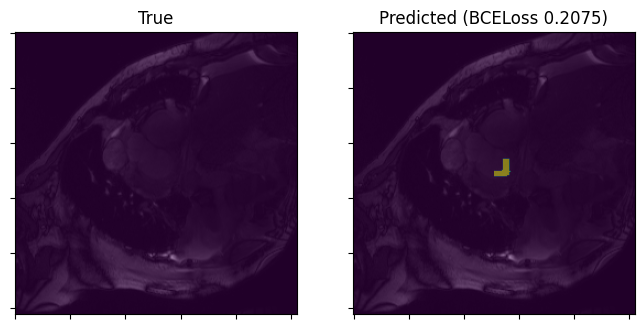

Test:   8%|▊         | 1/13 [00:00<00:02,  4.01it/s, val_loss=1.17]

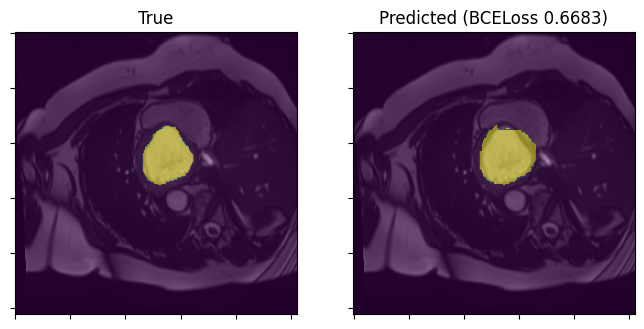

Test:  15%|█▌        | 2/13 [00:00<00:02,  4.07it/s, val_loss=1.12]

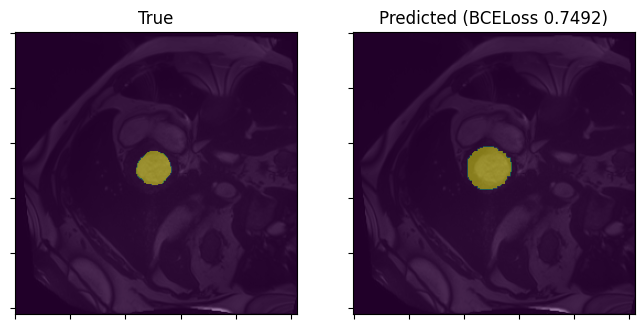

Test: 100%|██████████| 13/13 [00:01<00:00,  7.02it/s, val_loss=0.744]


Threshold : 0.15    Test Loss: 0.7035
Threshold : 0.15    Mean Dice Coefficient: 0.6377 ± 0.2815


Test:   0%|          | 0/13 [00:00<?, ?it/s, val_loss=7.66]

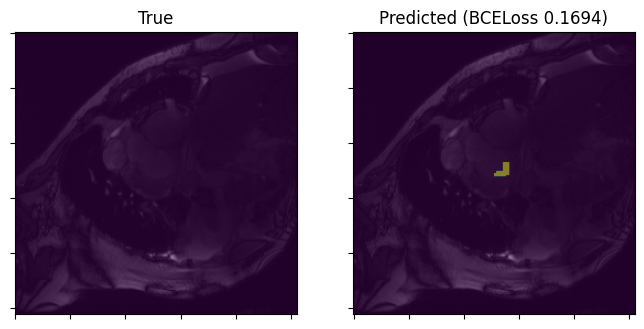

Test:   8%|▊         | 1/13 [00:00<00:02,  4.12it/s, val_loss=1.03]

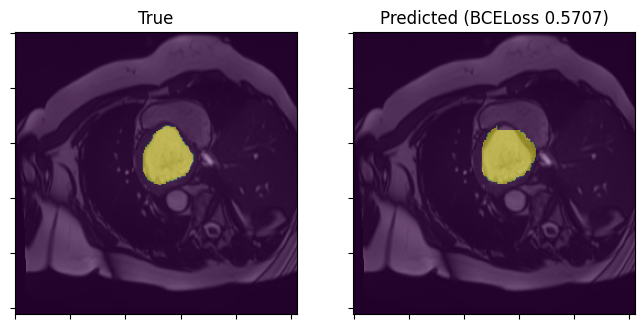

Test:  15%|█▌        | 2/13 [00:00<00:02,  4.07it/s, val_loss=0.942]

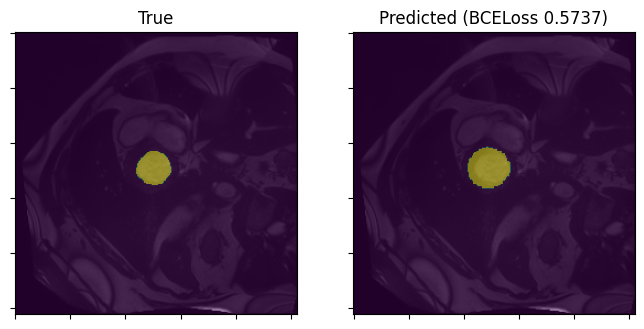

Test: 100%|██████████| 13/13 [00:01<00:00,  6.98it/s, val_loss=0.654]


Threshold : 0.2    Test Loss: 0.6190
Threshold : 0.2    Mean Dice Coefficient: 0.6498 ± 0.2945


Test:   0%|          | 0/13 [00:00<?, ?it/s, val_loss=8.5]

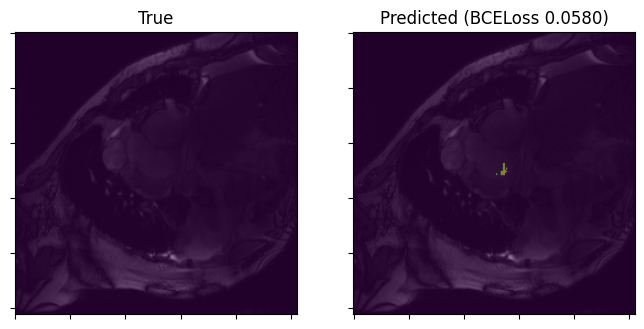

Test:   8%|▊         | 1/13 [00:00<00:03,  3.97it/s, val_loss=0.935]

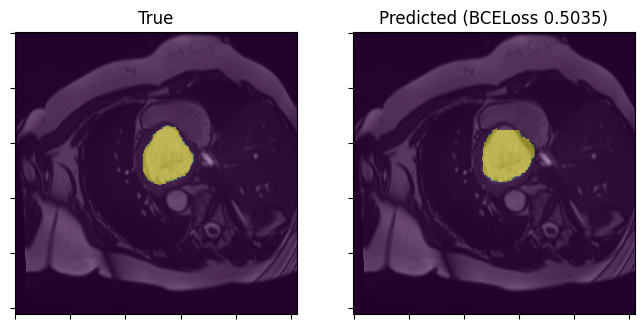

Test:  15%|█▌        | 2/13 [00:00<00:02,  3.95it/s, val_loss=0.768]

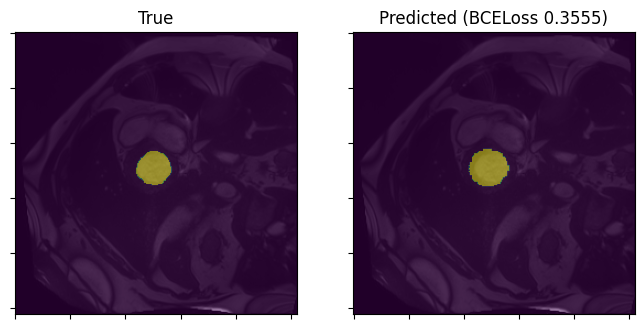

Test: 100%|██████████| 13/13 [00:02<00:00,  6.40it/s, val_loss=0.576]


Threshold : 0.3    Test Loss: 0.5446
Threshold : 0.3    Mean Dice Coefficient: 0.6536 ± 0.3172


Test:   0%|          | 0/13 [00:00<?, ?it/s, val_loss=11.4]

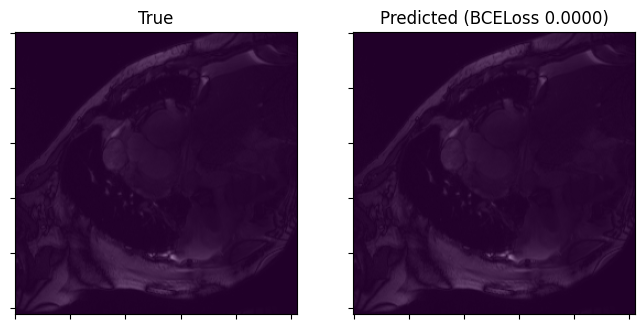

Test:   8%|▊         | 1/13 [00:00<00:02,  4.14it/s, val_loss=1.11]

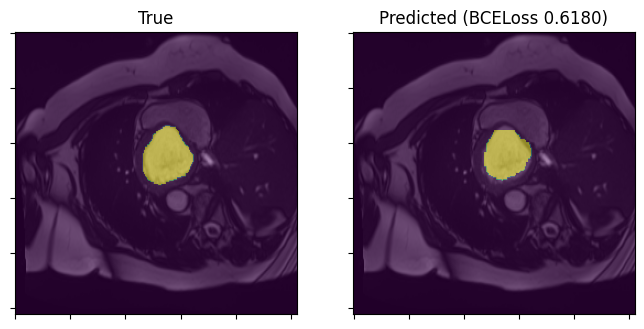

Test:  15%|█▌        | 2/13 [00:00<00:02,  4.06it/s, val_loss=0.759]

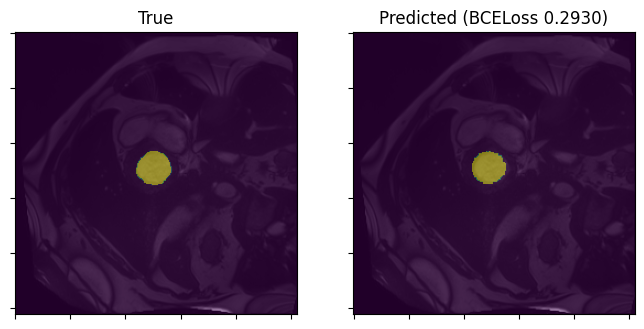

Test: 100%|██████████| 13/13 [00:01<00:00,  6.95it/s, val_loss=0.581]

Threshold : 0.5    Test Loss: 0.5498
Threshold : 0.5    Mean Dice Coefficient: 0.6060 ± 0.3432


In [21]:
# Validation
model.eval()
with torch.no_grad():
    for opt_threshold in [0.05, 0.1, 0.15, 0.2, 0.3, 0.5]:
        test_loss = 0.0
        displayed_patients = []
        dice_scores = []
        progress_bar = tqdm(test_loader, desc=f'Test')
        for i, (images, masks, pids) in enumerate(progress_bar):
            images, masks = images.to("cuda"), masks.to("cuda")
            outputs = model(images)
            outputs[outputs>opt_threshold] = 1
            outputs[outputs<=opt_threshold] = 0
            loss = get_loss(outputs, masks)
            test_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(val_loss=test_loss / ((i*batch_size)+1))
            
            dice_batch = []
            for j in range(len(images)):
                dice_score = dice_coefficient(outputs[j], masks[j])
                dice_batch.append(dice_score)
            dice_scores.extend(dice_batch)
            
            
            for j, pid in enumerate(pids):
                if pid not in displayed_patients and len(displayed_patients) < 3:
                    displayed_patients.append(pid)
                    plot_example(images[j], masks[j], outputs[j])
        
        test_loss /= len(test_loader.dataset)
        mean_dice = sum(dice_scores) / len(dice_scores)
        std_dice = torch.std(torch.tensor(dice_scores))
        print(f'Threshold : {opt_threshold}    Test Loss: {test_loss:.4f}')
        print(f'Threshold : {opt_threshold}    Mean Dice Coefficient: {mean_dice:.4f} ± {std_dice:.4f}')

In [22]:
# Testing
model.eval()
model = model.to("cuda")
test_loss = 0.0
displayed_patients = []
dice_scores = []
with torch.no_grad():
    progress_bar = tqdm(zip(batches_img, batches_msk), desc=f'Test')
    for i, (images, masks) in enumerate(progress_bar):
        images, masks = images.to("cuda"), masks.to("cuda")
        outputs = model(images)
        outputs[outputs>0.3] = 1
        outputs[outputs<=0.3] = 0
        loss = get_loss(outputs, masks)
        
        test_loss += loss.item() * images.size(0)
        progress_bar.set_postfix(val_loss=test_loss / ((i*batch_size)+1))
        
        dice_batch = []
        for j in range(len(images)):
            dice_score = dice_coefficient(outputs[j], masks[j])
            dice_batch.append(dice_score)
        dice_scores.extend(dice_batch)
        
test_loss /= len(test_loader.dataset)
mean_dice = sum(dice_scores) / len(dice_scores)
std_dice = torch.std(torch.tensor(dice_scores))
print(f'Test Loss: {test_loss:.4f}')
print(f'Mean Dice Coefficient: {mean_dice:.4f} ± {std_dice:.4f}')

Test: 68it [00:05, 11.89it/s, val_loss=0.581]

Test Loss: 3.0544
Mean Dice Coefficient: 0.6580 ± 0.3072
